# Activity 1a - 2D Image Transformations

Your name: Said Abdalrahim

Your ID number: 24177075

In this activity, we are going to look into 2D image transformations. We are going to look into the basics of image warping, including back-mapping to fill vacant pixels. We we also get the first taste of homogeneous coordinates and homogeneous transformations.

But first, we will start with the basics.

A couple of general notes.
 * First, I will often give you some template code to start working from in the cells. I will denote areas where you should insert your own code with a "your code here" comment.  
 * Occasionally, I will ask questions that you must also answer. These will be highlighted in a different colour.
 * In the first task of the module, some code is provided below, to help you on your way. However, as we progress through the module, I will give you less and less code to start.
 * I also spell out the steps in quite some detail here, however, as we progress, I will expect to not have to give such detail.
 * You must not use external libraries other than numpy for calculations and pyplot for displaying the images. We use OpenCV just to read the images - but this must not be used elsewhere. All the libraries are imported in the first cell.

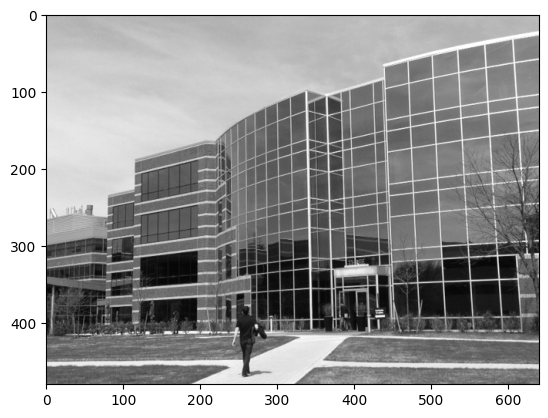

In [1]:
###################
# code given
import cv2                      # we use this mainly to read the files
import numpy as np              # the everpresent numpy
import matplotlib.pyplot as plt # does what it says on the tin - plotting

# Read in the image. We don't want to mess with colour, so we convert to grayscale.
# Let's also have a look at the image
img = cv2.imread('building1.jpg',cv2.IMREAD_GRAYSCALE)
plt.imshow(img,cmap='gray')

## A simple scaling

We want to implement a simple scaling, as is described in Video Lecture 1.2

The transform for scaling is given by the matrix:
$$
\textbf{T} = \begin{bmatrix}
a & 0 \\
0 & b 
\end{bmatrix}
$$
and thus, to transform the points in the image, we use
$$
\begin{bmatrix} x' \\ y' \end{bmatrix} = 
\begin{bmatrix}
a & 0 \\
0 & b 
\end{bmatrix}  
\begin{bmatrix} x \\ y \end{bmatrix}
$$
where $(x, y)$ is the point in the original image, and $(x', y')$ is the transformed point.


<font color='blue'>

#### Task:
    
In Python code, implement the scaling defined by the equations above. For each pixel in the original image, we will apply the transform, and put the pixel value at the resulting position in the output image.
    
1. Create the transformation matrix
1. Create an empty (black) image where the new image will be stored (hint [`np.zeros()`](https://numpy.org/doc/stable/reference/generated/numpy.zeros.html))
1. Iterate over all the pixels in the image (e.g., as a nested pair of for loops)
1. Apply the transformation to each pixel location (i.e., to the vector $(x, y)$ representing the pixel location). Get the result $(x', y')$ vector
1. Check that the resulting location $(x', y')$ is within the bounds of the image. You will get an error if you try to write outside of the image boundary.
1. Copy the pixel value from the input image location $(x, y)$ to the (valid) output image location $(x', y')$ (interpolated).
1. Display the resulting image ([`plt.imshow()`](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.imshow.html), as above)

    
Some hints:
* Images are stored in grids, and the index (coordinate $(x, y)$) of each grid is an integer value. However, after you transform the integer coordinate using $\textbf{T}$, there is no guarantee that the resulting coordinates $(x', y')$ will be integer values. 
* What do we do? This requires [**interpolation**](https://www.cambridgeincolour.com/tutorials/image-interpolation.htm), of which two popular methods are _bilinear_ and _bicubic_. However, for this task, we will just round our values to the nearest integer (which is, in fact, called _nearest neighbour_ interpolation).
* To do this, once you have transformed a point, I suggest to round to the nearest integer using [`np.rint()`](https://numpy.org/doc/stable/reference/generated/numpy.rint.html) and then cast to an `int` type using [`.astype(int)`](https://numpy.org/doc/stable/reference/generated/numpy.ndarray.astype.html)
    
</font>

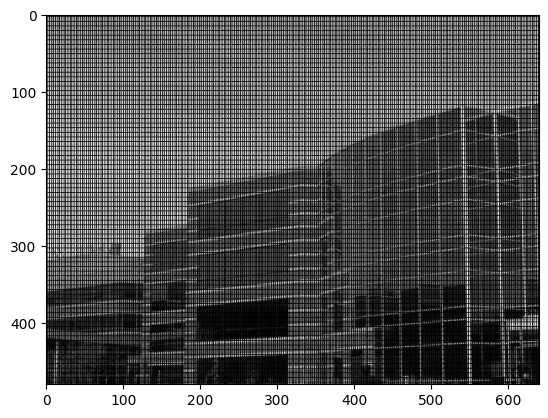

In [2]:
# Create a new empty image of the size of the original

def scale_image(scale_x, scale_y, shape):
    """
    Scales an image by the given scale factors along the x and y axes.
    Parameters:
    scale_x (float): The scaling factor along the x-axis.
    scale_y (float): The scaling factor along the y-axis.
    shape (tuple): The shape of the new image as (height, width).
    Returns:
    numpy.ndarray: The scaled image with the specified shape.
    """
    img_new = np.zeros(shape)
    
    # Create the transform matrix
    T = np.array([[scale_x,0],
                [0,scale_y]])


    for y in range(img.shape[0]):  # rows
        for x in range(img.shape[1]):  # columns
            
            pt = np.array([x,y])
            
            pt_new = T @ pt
            
            # check that the resulting point is within the image bounds
            pt_new_rounded = np.rint(pt_new).astype(int)
            if (0 <= pt_new_rounded[0] < img_new.shape[1]) and (0 <= pt_new_rounded[1] < img_new.shape[0]):
                img_new[pt_new_rounded[1]][pt_new_rounded[0]] = img[y][x]
    
    return img_new

img_new = scale_image(1.6, 1.2, img.shape)
# Display the new image
plt.imshow(img_new,cmap='gray')
plt.show()

<font color='blue'>

###### Question: Some of the image has disappeared. Why? [Hint](https://blogs.mathworks.com/steve/2006/04/28/spatial-transforms-forward-mapping/)

This happens because the new image created has a size equal to the original image, rather than the scaled size, this can be easily resolved by scaling the new image size as well.

<font color='blue'>

###### Question: Make sure your matrix contains scaling factors greater than 1 (i.e., causing an upscaling). Why are there black pixels?

the black pixels are called gaps and they happen when an output pixel from the scaling doesn't receive any input image pixels, this can be resolved by using inverse mapping.

## Back-mapping the pixels

In the last task, we ended up with black pixels (vacant pixels) in the resulting image. Now we will address this using the method of back mapping, also call [inverse mapping](https://blogs.mathworks.com/steve/2006/05/05/spatial-transformations-inverse-mapping/).

Let's look at forward mapping first. Consider each input image pixel in turn. For each input image pixel:

Forward mapping:
1. Determine its location in input space, $(x, y)$.
1. Map that location to output space using $(x',y')^\top = \textbf{T}(x,y)^\top$.
1. Figure out which output pixel contains the location $(x',y')$. I.e., convert to integer values.
1. Copy the input pixel value to that output pixel.

This diagram illustrates the procedure:
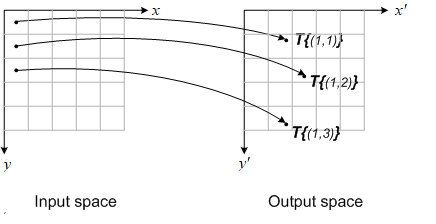


Forward mapping has two main disadvantages as a computational procedure: gaps and overlaps. Depending on specific spatial transform function, you may have some output pixels that did not receive any input image pixels; these are the gaps. You may also have some output pixels that received more than one input image pixel; these are the overlaps. In both cases, it is challenging to figure out a reasonable way to set those output pixels.

Because of the disadvantages of the forward mapping method, most of the practical implementations use a different technique, called back/inverse mapping.

Here's how it works:

Locate your output image pixel grid somewhere in output space. Then for each output pixel on the grid:

1. Apply the **inverse** spatial transformation to determine the corresponding location in input space: $(x,y)^\top = \textbf{T}^{-1}(x',y')^\top$.
1. Using the input image pixels nearest to $(x,y)$, *interpolate* to get an approximate value for the input image at $(x,y)$.
1. Use that value for the output pixel.

This diagram illustrates the procedure:
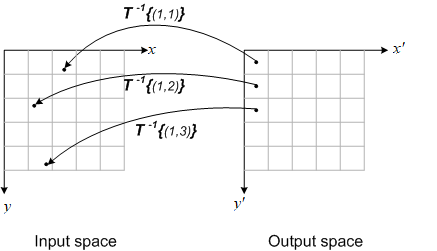

This method completely avoids problems with gaps and overlaps. You just have to decide which interpolation method to you (below, as above, we use the simplest nearest neighbour interpolation), and you also have to establish a rule for what value to use when $(x,y)$ isn't within the input image pixel grid.


<font color='blue'>

#### Task:
    
In Python code, implement the scaling using back mapping. For each pixel in the output image, we will apply the inverse transform, and copy the pixel value to the resulting position in the output image.
    
1. Create the transformation matrix
1. Invert the transformation ([`np.linalg.inv()`](https://numpy.org/doc/stable/reference/generated/numpy.linalg.inv.html))
1. Create an empty (black) image where the new image will be stored (hint [`np.zeros()`](https://numpy.org/doc/stable/reference/generated/numpy.zeros.html))
1. Iterate over all the pixels in the **output** image (e.g., as a nested pair of for loops)
1. Apply the inverse transformation to each output pixel location (i.e., to the vector $(x', y')$ representing the output pixel location). Get the result $(x, y)$ vector representing the input pixel location
1. Check that the resulting location $(x, y)$ is within the bounds of the input image. You will get an error if you try to read outside of the image boundary.
1. Copy the (valid) pixel value from the input image location $(x, y)$ (interpolated) to the output image location $(x', y')$.
1. Display the resulting image ([`plt.imshow()`](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.imshow.html), as above)

As above, use nearest neighbour interpolation.
    
</font>

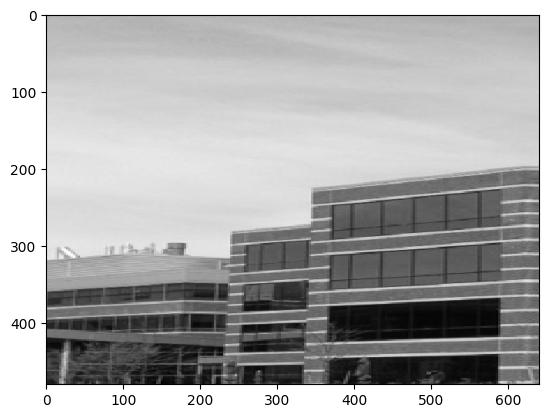

In [3]:
def back_map_transform(T, shape):
    """
    Applies a backward mapping transformation to an image using the given transformation matrix.
    Parameters:
    T (numpy.ndarray): The transformation matrix to be applied.
    shape (tuple): The shape of the output image (height, width).
    Returns:
    numpy.ndarray: The transformed image with the specified shape.
    """
    T_inv = np.linalg.inv(T)
    img_new = np.zeros(shape)

    for y_new in range(img_new.shape[0]):  # rows
        for x_new in range(img_new.shape[1]):  # cols

            pt = np.array([x_new,y_new])

            # apply the inverse transform to the scaled point to get original point estimate
            pt_new = T_inv @ pt

            # round the point to the nearest integer
            pt_new_rounded = np.rint(pt_new).astype(int)
            # check that the resulting point is within the input image bounds
            if (0 <= pt_new_rounded[0] < img.shape[1]) and (0 <= pt_new_rounded[1] < img.shape[0]):
                img_new[y_new][x_new] = img[pt_new_rounded[1]][pt_new_rounded[0]]
    
    return img_new

def inverse_scale(scale_x, scale_y, shape):
    """
    Applies an inverse scaling transformation to a given shape.

    Parameters:
    scale_x (float): The scaling factor along the x-axis.
    scale_y (float): The scaling factor along the y-axis.
    shape (array-like): The shape to be transformed, typically a set of points.

    Returns:
    array-like: The transformed shape after applying the inverse scaling.
    """
    T = np.array([[scale_x,0],
                 [0,scale_y]])
    return back_map_transform(T, shape)

img_new = inverse_scale(3, 1.2, img.shape)

plt.imshow(img_new,cmap='gray')
plt.show()

<font color='blue'>

###### Question: Why does this fill the gaps?

for the gaps we calculated the inverse transform and then interpolate the point coordinates, and then take the value of the original estimated pixel and use it for the gaps.

<font color='blue'>

###### Question: We use the inverse of the scaling matrix above. To estimate this, we use the Numpy function. But how would we calculate it directly, for the scaling matrix? Or, to put it another way, what does the inverse of the scaling matrix look like?

the inverse of the scaling matrix would simply be the inverse of the scaling itself, for example if the scaling matrix is S = [[sx, 0],[0,sy]] then S^-1 = [[1/sx,0],[0,1/sy]].
The inverse here reverts the scaling operation originally done on the matrix, or a better way of saying it, is that it scales it back in the opposite direction.

## More transforms

### Shear and Rotation

You now have a template for applying arbitrary 2D transforms to an image, using back-mapping.

Recall, the shearing transform is given by
$$
\textbf{T}_s = \begin{bmatrix}
1 & a \\
b & 1 
\end{bmatrix}
$$
Where $a$ and $b$ are the shearing parameters, in this case. Rotation is given by
$$
\textbf{T}_r = \begin{bmatrix}
\cos(\theta) & -\sin(\theta) \\
\sin(\theta) & \cos(\theta) 
\end{bmatrix}
$$
Where $\theta$ is the rotation angle. Rotation matrices are typically also denoted $\textbf{R}$.

<font color='blue'>

#### Task:

In two separate cells, transform the the image using:
 * Shear
 * Rotation
    
You can feel free to copy down and adapt your code from above.

apply_transform is a general function that is used in conjunction with any transform to apply it to the pixels

this first cell has the utility function definition as well as the shear operation

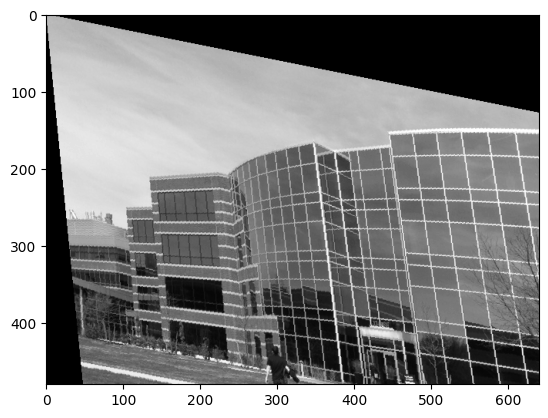

In [4]:
def shear(scale_a, scale_b, shape):
    """
    Applies a shear transformation to a given shape.

    Parameters:
    scale_a (float): The shear factor along the x-axis.
    scale_b (float): The shear factor along the y-axis.
    shape (ndarray): The coordinates of the shape to be transformed.

    Returns:
    ndarray: The coordinates of the transformed shape.
    """
    T = np.array([[1,scale_a],
                 [scale_b,1]])
    return back_map_transform(T, shape)


img_new = shear(0.1, 0.2, img.shape)

# Display the new image
plt.imshow(img_new,cmap='gray')
plt.show()

this cell contains the rotation operation using the defined utility function above

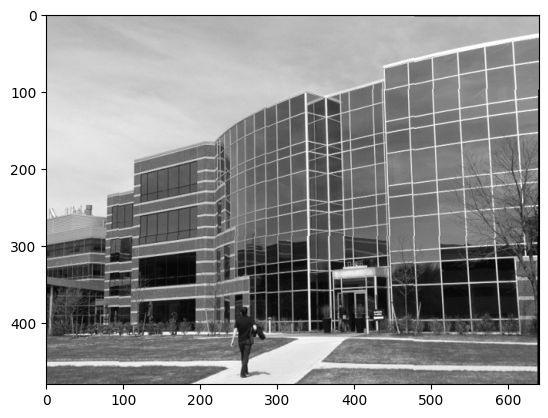

In [5]:
def rotate(theta):
    """
    Generates a 2D rotation matrix for a given angle.
    Parameters:
    theta (float): The angle in radians by which to rotate.
    Returns:
    numpy.ndarray: A 2x2 rotation matrix.
    """
    theta = np.radians(theta)
    T = np.array([[np.cos(theta), -np.sin(theta)],
                  [np.sin(theta), np.cos(theta)]])
        
    return T

# degree in radians
img_new = back_map_transform(rotate(0.3), img.shape)

plt.imshow(img_new,cmap='gray')
plt.show()

<font color='blue'>

###### Question: why does the rotation "rotate" in a clockwise manner with positive angles?

this is because the positive y axis in the image points downwards, that means when we rotate by a positive angle we are rotating clockwise, and thus the image goes down.

## Combining 2D transformations

The 2D transformations can be combined together, through matrix multiplication. Say we have two different transforms, $\textbf{T}_1$ and $\textbf{T}_2$. We have an image, that we wish to transform by $\textbf{T}_2$ first, and then $\textbf{T}_1$. Well, instead of doing two matrix multiplications on every point in the image, we can combine the transformations into a single matrix through matrix multiplication ($\textbf{T} = \textbf{T}_1\textbf{T}_2$, where $\textbf{T}$ is the overall matrix representation of the two transformations), and thus apply the two transforms using a single matrix multiplication.

<font color='blue'>
    
#### Task: 

Combine the shear and rotation transformation by defining each matrix separately, and then multiplying them together.
    
In one code cell, apply it as $\textbf{T} = \textbf{T}_s\textbf{T}_r$
    
In another code cell, apply it as $\textbf{T} = \textbf{T}_r\textbf{T}_s$ (inverting the order of multiplication of the matrices)

in this first cell we define a function that creates the transformation matrices for us. following this we apply the transform T_S . T_R, which does the rotation first then the shearing.

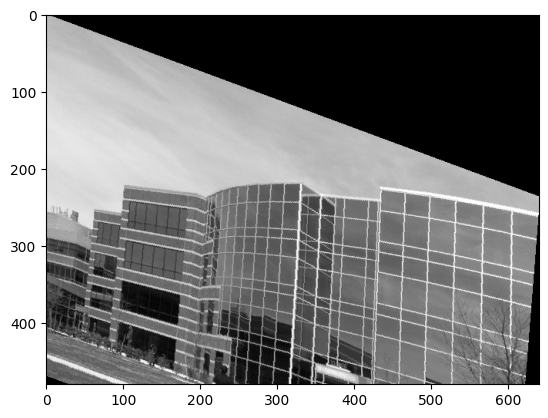

In [10]:
def get_tr_ts(scale_a, scale_b, theta, shape):
    """
    Generate transformation matrices for rotation and scaling, and return them along with the shape.

    Parameters:
    scale_a (float): Scaling factor for the x-axis.
    scale_b (float): Scaling factor for the y-axis.
    theta (float): Angle in radians for the rotation transformation.
    shape (array-like): The shape to be transformed.

    Returns:
    list: A list containing the rotation matrix, scaling matrix, and the shape.
    """
    T_R = rotate(theta)
    T_S = np.array([[1,scale_a],
                 [scale_b,1]]) 
    return [T_R, T_S, shape]

T_R, T_S, shape = get_tr_ts(0.1, 0.2, 10, img.shape)

new_img = back_map_transform(T_S @ T_R, shape)

# display the new image
plt.imshow(new_img,cmap='gray')
plt.show()

in this cell we reuse the transformation matrices but apply them in the opposite order, with shear first then rotation

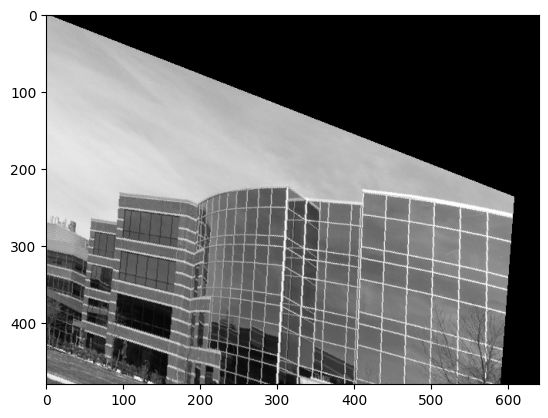

In [11]:
new_img = back_map_transform(T_R @ T_S, shape)

# display the new image
plt.imshow(new_img,cmap='gray')
plt.show()

<font color='blue'>

###### Question: When the two transforms are applied in different order, the result is different. Why is this?

the simple answer to this is that matrix multiplication is non commutative, 
in this particular example the shear alters the spacing of points along a particular axis, and this is affected differently depending on whether you rotate the image before or after the shear.

# Extra Credit

Some extra credit if you complete the following task. I will give you extra marks to compesnate for any failings in the other tasks in this e-tivity (if any).

<font color='blue'>
    
#### Task:

Take one of the transforms above, and do an implementation where you expland the size of the image to account for pixels that are outside the resulting image in the original implementation. You only need to account for the extra pixels in the positive axis dimensions. That is, if a pixel is transformed to a point with negative dimension values, you can still ignore this.
    
**Hint**: You can figure out the resulting image dimensions by forward transforming the four corners of the image.

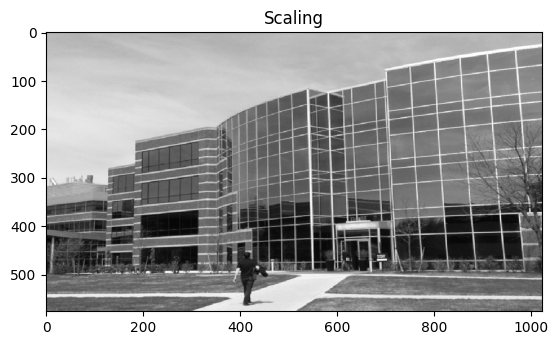

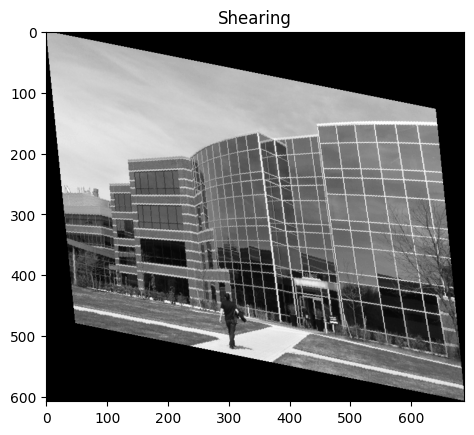

In [12]:
def scale_image_resize(scale_x, scale_y, shape):
    """
    Scales an image by the given scale factors and returns the transformed image.
    Parameters:
    scale_x (float): The scaling factor in the x direction.
    scale_y (float): The scaling factor in the y direction.
    shape (tuple): The original shape of the image as a tuple (height, width).
    Returns:
    numpy.ndarray: The transformed image after applying the scaling transformation.
    """
    # calc the scaled shape
    shape = ((int)(shape[0] * scale_y), (int)(shape[1] * scale_x))
    
    T = np.array([[scale_x,0],
                [0,scale_y]])
    
    return back_map_transform(T, shape)

def shear_image_resize(scale_a, scale_b, shape):
    """
    Applies a shear transformation to an image and resizes it accordingly.

    Parameters:
    scale_a (float): The shear factor along the x-axis.
    scale_b (float): The shear factor along the y-axis.
    shape (tuple): A tuple representing the shape of the image (height, width).

    Returns:
    numpy.ndarray: The transformed image after applying the shear and resizing.
    """
    shape = ((int)(shape[0] + abs(scale_b * shape[1])), (int)(shape[1] + abs(scale_a * shape[0])))
    T = np.array([[1,scale_a],
                 [scale_b,1]])
    return back_map_transform(T, shape)

img_new = scale_image_resize(1.6, 1.2, img.shape)

plt.title('Scaling')
plt.imshow(img_new,cmap='gray')
plt.show()

img_new = shear_image_resize(0.1, 0.2, img.shape)

plt.title('Shearing')
plt.imshow(img_new,cmap='gray')
plt.show()